In [5]:
%autosave 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosaving every 2 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analíse de reviews de videogames da Amazon

## Referencias
- [NLTK Book Online](http://www.nltk.org/book/)

* __Turing Talks__
    - [Introdução a NLTK com Dom Casmurro](https://medium.com/turing-talks/uma-an%C3%A1lise-de-dom-casmurro-com-nltk-343d72dd47a7)
    - [Introdução ao Processamento de Linguagem Natural com Baco Exu do Blues
](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-ao-processamento-de-linguagem-natural-com-baco-exu-do-blues-17cbb7404258)
    - [Introdução a Bag of Words e TF-IDF](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-a-bag-of-words-e-tf-idf-43a128151ce9)
        - [notebook](https://github.com/turing-usp/BoW-e-TFIDF/blob/master/BoW_e_TFIDF.ipynb)
    - [Sua primeira análise de sentimentos com scikit-learn](https://medium.com/turing-talks/sua-primeira-an%C3%A1lise-de-sentimentos-com-scikit-learn-a47c088ea7bd)
        - [modelos](https://www.kaggle.com/camillafonseca/nlp-an-lise-de-sentimento-do-olist-para-iniciantes#Modelos)
    - [Como Avaliar Seu Modelo de Classificação](https://medium.com/turing-talks/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-acd2a03690e)

In [75]:
from rich import print # print ficar bonitinho
from IPython.display import display

In [7]:
import pandas as pd
import numpy as np

In [8]:
#import nltk
from nltk.corpus import stopwords # remover stopwords
from nltk import WordNetLemmatizer
import string, re # remover pontucao
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
#nltk.download()

In [10]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

In [11]:
plt.style.use('seaborn')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : '16'}

mpl.rc('font', **font)

In [142]:
from wordcloud import WordCloud
import cv2 as cv # Pra mascara do wordcloud

In [58]:
dfReview = pd.read_csv('video_games_reviews_test.csv')
#dfReviewTrain = pd.read_csv('video_games_reviews_train.csv')
#dfReviewValid = pd.read_csv('video_games_reviews_dev.csv')

## Pré-processamento e Análise do corpus


* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
    * [Sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix)
* [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)
* [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

### Visualizacao dos dados e tratamento das colunas

In [59]:
dfReview.head(10)

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,12154,25980,A16416X67B4ZKJ,B00005V6BB,"""mcfly70""","[1, 1]","MOH was good and all, but when you reach the c...",4,MOH: THE ACTUAL WAR WAS BETTER THE 3RD MCFLY R...,1035158400,"10 21, 2002"
1,7333,215010,A2Q2ADX9C9I5WZ,B00AZWE7ES,MCRC,"[0, 4]",I am so glad I only paid $15 for this game dur...,2,15 fps? really?,1399334400,"05 6, 2014"
2,6703,188851,A30IXQWBRD3GU9,B0053BCO00,Jerry,"[0, 0]",Forget this mario kart get mario kart ds or th...,3,ehhhh,1373414400,"07 10, 2013"
3,5649,93541,A1S7NYZF69KYAP,B000VRCNLG,Peanut Pedro,"[0, 1]",When I purchased this game from Amazon I certa...,1,Defective Disk/Great Seller,1348963200,"09 30, 2012"
4,2955,24169,A2MPAOYEC1KWEI,B00005R5PO,Mali,"[0, 0]",I love platform games but not many are out the...,4,It's not Spyro...,1073260800,"01 5, 2004"
5,365,19671,ACUYXGCMWVF7S,B00005MO5E,Matthieu P. Raillard,"[7, 11]","Madden 2002 is an improvement over 2001, for s...",3,"Solid, with one FATAL flaw...",999129600,"08 30, 2001"
6,5078,153185,A28TPVUQ4WKKLU,B003GT8IL0,Brotherhood1994x,"[0, 0]",This game is a huge step up for Warner Bros. T...,4,I love the F.E.A.R. games,1351641600,"10 31, 2012"
7,1310,114822,A2HKGZ1QKK9TU0,B001F0OOF6,"Spirited Treasure ""Spirit""","[1, 2]",This game is horribly glitchy. Even though the...,1,don't waste your money,1229731200,"12 20, 2008"
8,4251,52562,A1UPNUCA5ATMPP,B0006TO2HM,David Keyworth,"[7, 15]",Is Apollo Justice a true Ace Attorney game? Ye...,3,To all fans of Phoenix Wright: I'm very sorry.,1221350400,"09 14, 2008"
9,23,80948,A1KBV71PGFFPVV,B000N60GPK,"D. Bowman ""Tech Dork""","[5, 6]",There is already a lot said in the other revie...,4,Play at the same time with your kids (two-play...,1214611200,"06 28, 2008"


In [60]:
dfReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         2500 non-null   int64 
 1   index           2500 non-null   int64 
 2   reviewerID      2500 non-null   object
 3   asin            2500 non-null   object
 4   reviewerName    2471 non-null   object
 5   helpful         2500 non-null   object
 6   reviewText      2499 non-null   object
 7   overall         2500 non-null   int64 
 8   summary         2500 non-null   object
 9   unixReviewTime  2500 non-null   int64 
 10  reviewTime      2500 non-null   object
dtypes: int64(4), object(7)
memory usage: 215.0+ KB


* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* helpful - helpfulness rating of the review, e.g. 2/3
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)

[source](https://jmcauley.ucsd.edu/data/amazon/)

In [78]:
# verificar se existem valores vazios nas colunas de interesse: reviewText, summary e overall
print('[bold red]reviewText:[/bold red]')
display(dfReview[dfReview['reviewText'].isna()])
print()
print('[bold red]summary:[/bold red]')
display(dfReview[dfReview['summary'].isna()])
print()
print('[bold red]overall:[/bold red]')
display(dfReview[dfReview['overall'].isna()])

reviewText:

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
739,4377,102846,ACVE93JPMM92X,B0014ULQB2,Andrew M. Whipple III,"[7, 9]",NaN,4,The most gratuitous destruction this generatio...,1251417600,"08 28, 2009"


summary:

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime


overall:

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime


In [79]:
# remover valores NaN do texto
#dfReview.dropna(axis=0, subset=['reviewText'], inplace=True)

In [93]:
# como so ha NaN no reviewText ao unir com o summary que complementa o texto
# nao vai mais haver NaN, portanto nao ha nescessidade de excluir a linha
dfReview['reviewText'] = dfReview.apply(lambda x: x.summary + ' ' + x.reviewText if str(x.reviewText) != 'nan' else x.summary, axis=1)

In [96]:
# removendo colunas desnecessarias:
dfReview.drop(['level_0', 'index', 'unixReviewTime', 'reviewerID', "reviewerName", "summary"], axis=1, inplace=True)

In [97]:
# convertendo reviewTime em datetime
dfReview['reviewTime'] = pd.to_datetime(dfReview['reviewTime'], format='%m %d, %Y')

In [98]:
# criar coluna binaria do overall 1 if nota > 3 else 0
dfReview['overallBinary'] = dfReview['overall'].apply(lambda x: 1 if x > 3 else 0)

In [99]:
dfReview

,asin,helpful,reviewText,overall,reviewTime,overallBinary
0,B00005V6BB,"[1, 1]",MOH: THE ACTUAL WAR WAS BETTER THE 3RD MCFLY R...,4,2002-10-21,1
1,B00AZWE7ES,"[0, 4]",15 fps? really? I am so glad I only paid $15 f...,2,2014-05-06,0
2,B0053BCO00,"[0, 0]",ehhhh Forget this mario kart get mario kart ds...,3,2013-07-10,0
3,B000VRCNLG,"[0, 1]",Defective Disk/Great Seller When I purchased t...,1,2012-09-30,0
4,B00005R5PO,"[0, 0]",It's not Spyro... I love platform games but no...,4,2004-01-05,1
...,...,...,...,...,...,...
2495,B004FSE52C,"[5, 12]",sucks Too much quicktime nonsense. Too many c...,1,2013-10-27,0
2496,B000BNKSVC,"[2, 7]",quickly gets old... it's really a superficial ...,2,2006-03-18,0
2497,B000FIVC2W,"[0, 1]",a MUST PLAY I wanna say this is the best game ...,5,2010-09-22,1
2498,B0002XL3BA,"[2, 4]","A whole lot of fun, for adults only This is on...",5,2005-04-11,1


### Remocao de stopwords e pontuacao

In [100]:
# Lista com as stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [101]:
def tratamento_basico(texto,
                      pontuacao = re.compile('|'.join(map(re.escape, string.punctuation))),
                      stpwrds = stopwords.words('english')):
    """tratamento basico do texto com remocao de pontucao e e stopwords
    
    input:
         - texto: (str) -> menssagem a ser processada
         - pontuacao (re.Pattern) -> caracteres de pontuacao a serem removidos
                                     compilados em uma regex
                                     default: providos pelo string.punctuation
                                              usando o re.compile('|'.join(map(re.escape, string.punctuation)))
         - stpwrds (list)  -> lista de stopwords
                              default: providos pela funcao stopwords.words('english') da lib nltk.corpus
    output:
         (str) ->  menssagem pre-processada em caixa baixa
    """
    
    # Caixa baixa
    texto = texto.lower()
    
    # para pontucao so usar o metodo sub da regex de entrada
    texto = pontuacao.sub("", texto)
    
    # para as stopwords fazer por compreensao de lista, juntando chars em
    # palavras para nao remover as sopwords que estejam dentro de uma outra palavra
    # e usar os texto em caixa baixa para dar match
    texto = [palavra for palavra in texto.split() if palavra not in stpwrds]
    
    # Retorna vetor pra um texto
    texto = " ".join(texto)
    
    return texto

In [122]:
print('[bold red]antes do tratamento_basico():[/bold red]')
print()
dfReview['reviewText'].head(10)

antes do tratamento_basico():

0    MOH: THE ACTUAL WAR WAS BETTER THE 3RD MCFLY R...
1    15 fps? really? I am so glad I only paid $15 f...
2    ehhhh Forget this mario kart get mario kart ds...
3    Defective Disk/Great Seller When I purchased t...
4    It's not Spyro... I love platform games but no...
5    Solid, with one FATAL flaw... Madden 2002 is a...
6    I love the F.E.A.R. games This game is a huge ...
7    don't waste your money This game is horribly g...
8    To all fans of Phoenix Wright: I'm very sorry....
9    Play at the same time with your kids (two-play...
Name: reviewText, dtype: object

In [261]:
print('[bold red]depois do tratamento_basico():[/bold red]')
print()

# remover os numeros tambem
# incluir a apalvra game nos stopwords
StopWords = stopwords.words('english')
StopWords.append('game')
StopWords.append('games')
dfReview['reviewText_prep'] = dfReview['reviewText'].apply(lambda x:(tratamento_basico(x, 
                                                                                       pontuacao=re.compile('|'.join(map(re.escape, string.punctuation+'1234567890'))),
                                                                                       stpwrds=StopWords)))
dfReview['reviewText_prep'].head(10)

depois do tratamento_basico():

0    moh actual war better rd mcfly review moh good...
1    fps really glad paid sonys golden week saleit ...
2    ehhhh forget mario kart get mario kart ds one ...
3    defective diskgreat seller purchased amazon ce...
4    spyro love platform many tried crash bandicoot...
5    solid one fatal flaw madden improvement sure e...
6    love fear huge step warner bros graphics mecha...
7    dont waste money horribly glitchy even though ...
8    fans phoenix wright im sorry apollo justice tr...
9    play time kids twoplayer coop already lot said...
Name: reviewText_prep, dtype: object

In [262]:
# adiciona coluna com quantidade de palavras
dfReview['len_review_words'] = dfReview['reviewText_prep'].apply(lambda x:len(x.split()))

In [263]:
dfReview

,asin,helpful,reviewText,overall,reviewTime,overallBinary,reviewText_prep,len_review_words
0,B00005V6BB,"[1, 1]",MOH: THE ACTUAL WAR WAS BETTER THE 3RD MCFLY R...,4,2002-10-21,1,moh actual war better rd mcfly review moh good...,81
1,B00AZWE7ES,"[0, 4]",15 fps? really? I am so glad I only paid $15 f...,2,2014-05-06,0,fps really glad paid sonys golden week saleit ...,46
2,B0053BCO00,"[0, 0]",ehhhh Forget this mario kart get mario kart ds...,3,2013-07-10,0,ehhhh forget mario kart get mario kart ds one ...,16
3,B000VRCNLG,"[0, 1]",Defective Disk/Great Seller When I purchased t...,1,2012-09-30,0,defective diskgreat seller purchased amazon ce...,57
4,B00005R5PO,"[0, 0]",It's not Spyro... I love platform games but no...,4,2004-01-05,1,spyro love platform many tried crash bandicoot...,67
...,...,...,...,...,...,...,...,...
2495,B004FSE52C,"[5, 12]",sucks Too much quicktime nonsense. Too many c...,1,2013-10-27,0,sucks much quicktime nonsense many cutscenes h...,15
2496,B000BNKSVC,"[2, 7]",quickly gets old... it's really a superficial ...,2,2006-03-18,0,quickly gets old really superficial lacking re...,27
2497,B000FIVC2W,"[0, 1]",a MUST PLAY I wanna say this is the best game ...,5,2010-09-22,1,must play wanna say best ps adults battle syst...,38
2498,B0002XL3BA,"[2, 4]","A whole lot of fun, for adults only This is on...",5,2005-04-11,1,whole lot fun adults one fun video ive played ...,41


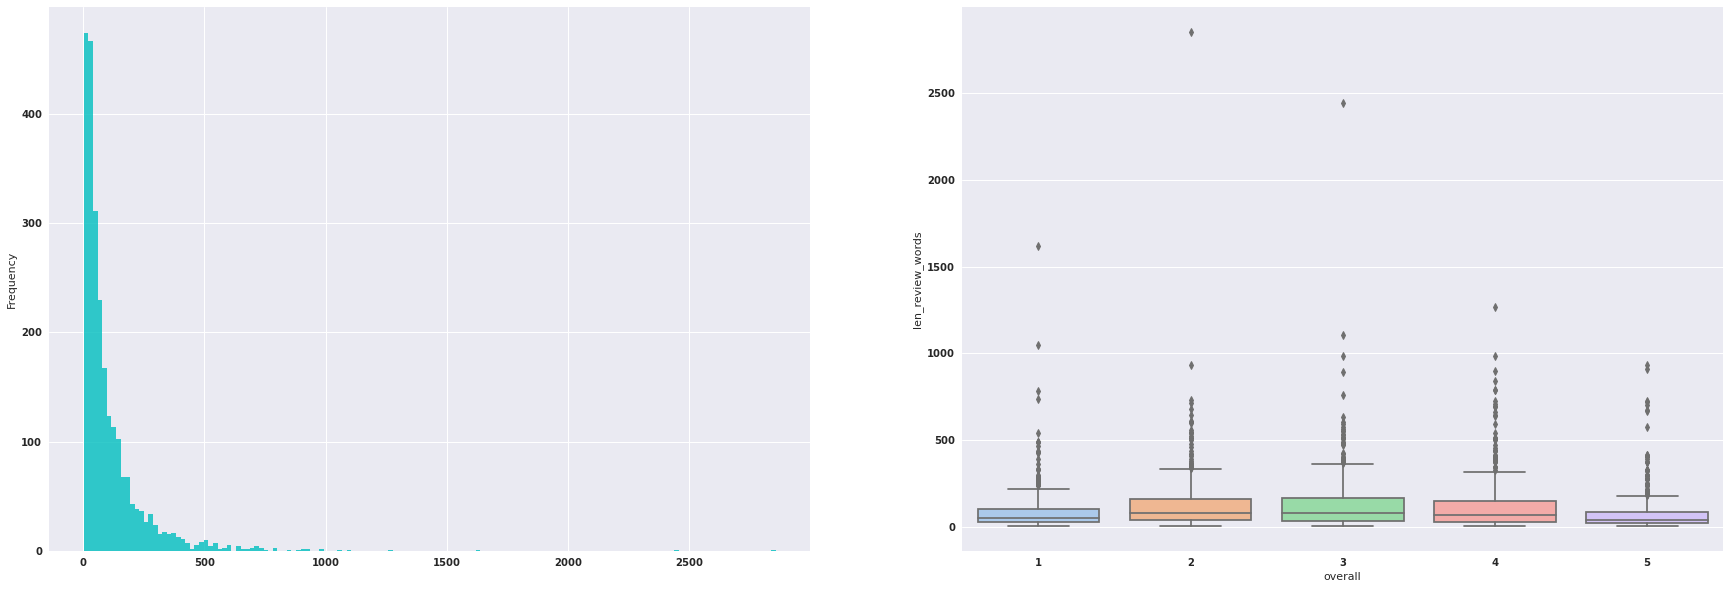

In [264]:
#plt.figure(figsize=(20,9))
#gs = gridspec.GridSpec(2, 1)

#ax0 = plt.subplot(gs[0:1])
#ax1 = plt.subplot(gs[1:])

#p = dfReview['len_review_words'].plot(kind='box', ax=ax0, vert=False, )
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
p = dfReview['len_review_words'].plot(kind='hist', bins=150, ax=ax[0], alpha=.8, color='c', label='words')
p = sns.boxplot(data=dfReview, x='overall', y='len_review_words', palette='pastel', ax=ax[1])

### Lemmatização

In [265]:
lemmantizador = nltk.WordNetLemmatizer()
def lemmanizacao(texto):
    """retorna texto lemmantizado
    
    entrada:
        - texto(str): string a ser lemmantizada
    saida:
        - (str): texto de entrada lemmantizado
    """
    
    tokentxt =  [lemmantizador.lemmatize(palavra) for palavra in texto.split()]
    
    return ' '.join(tokentxt)

In [266]:
dfReview['reviewText_prep'] =  dfReview['reviewText_prep'].apply(lambda x:lemmanizacao(x))

In [267]:
dfReview['reviewText_prep']

0       moh actual war better rd mcfly review moh good...
1       fps really glad paid sonys golden week saleit ...
2       ehhhh forget mario kart get mario kart d one w...
3       defective diskgreat seller purchased amazon ce...
4       spyro love platform many tried crash bandicoot...
                              ...                        
2495    suck much quicktime nonsense many cutscenes ho...
2496    quickly get old really superficial lacking rea...
2497    must play wanna say best p adult battle system...
2498    whole lot fun adult one fun video ive played l...
2499    shouldve made like p version unlike p version ...
Name: reviewText_prep, Length: 2500, dtype: object

In [268]:
ret, mask = cv.threshold(cv.imread('controller.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

In [269]:
#plt.imshow(mask)
#plt.axis("off")

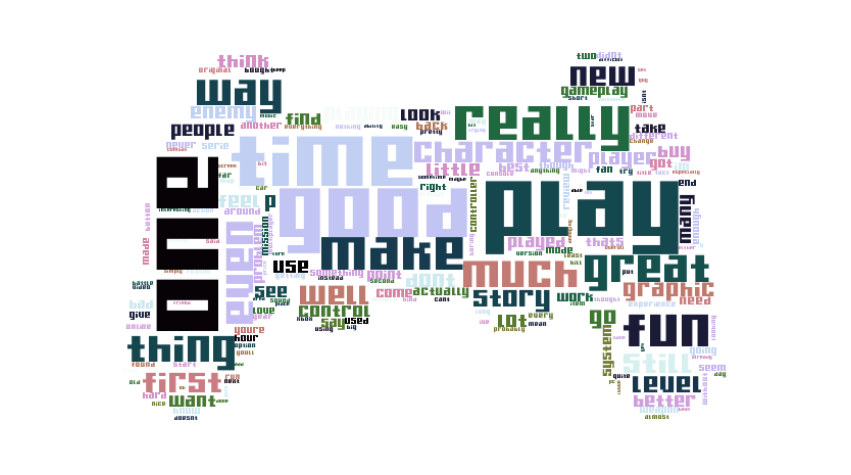

In [271]:
text = ' '.join(list(dfReview['reviewText_prep']))

wordcloud = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=mask, 
                      font_path='Gamer.ttf',
                      colormap="cubehelix",).generate(text)

plt.figure(figsize=(15,10))
p = plt.imshow(wordcloud, interpolation='bilinear')
p = plt.axis("off")